# Molecular Quantum Mechanics (CB2070)
## SOLUTION Computer lab 3: Dissociation of covalent bonds
---
Name: J.H. Andersen with stolen content from VT24 and VT25 student submissions

Date: July 2025

---

In [1]:
import veloxchem as vlx
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
mol_str = """
H     0.000000    0.000000   -0.370500
H     0.000000    0.000000    0.370500
"""
molecule = vlx.Molecule.read_str(mol_str, units='angstrom')

### 1.a Calculate the HF ground state

In [3]:
scf_hf_drv = vlx.ScfRestrictedDriver()
basis = vlx.MolecularBasis.read(molecule, 'sto-3g')
scf_hf_results = scf_hf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

### 1.b Plot the bonding, $\sigma_g$, and anti-bonding, $\sigma_u$, molecular orbitals

In [7]:
# setup the visualization driver
vis_drv = vlx.VisualizationDriver()

# get the MO values and plot
mol_orbs = scf_hf_results['C_alpha']

# define the nuclear distance range we want to plot
n = 200
r = np.linspace(-4, 4, n)
z_coords = np.zeros((n,3))
z_coords[:, 2] = r  # radial points along the z-axis

## z direction
# get the values of orbitals: we have five fully occupied MOs
mo_1s_g = np.array(vis_drv.get_mo(z_coords, molecule, basis, mol_orbs, 0))
mo_1s_u = np.array(vis_drv.get_mo(z_coords, molecule, basis, mol_orbs, 1))

# adjust signs
mo_1s_g = np.sign(mo_1s_g[10]) * mo_1s_g
mo_1s_u = np.sign(mo_1s_u[10]) * mo_1s_u

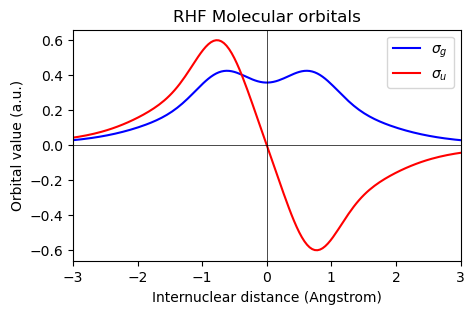

In [17]:
plt.figure(figsize=(5,3))

# Along z-axis
plt.plot(r, mo_1s_g, label = '$\\sigma_g$', color='b')
plt.plot(r, mo_1s_u, label = '$\\sigma_u$', color='r')
plt.axhline(color='k', linewidth=0.5)
plt.axvline(0.0, color='k', linewidth=0.5)
plt.title(r'RHF Molecular orbitals')
plt.xlabel(r'Internuclear distance (Angstrom)')
plt.ylabel(r'Orbital value (a.u.)')
plt.xlim([-3.0, 3.0])
plt.legend()

plt.show()

#### Discuss what you see in terms of the underlying LCAO

The symmetric $(\sigma_g)$ and antisymmetric $(\sigma_u)$ linear combinations of two 1s orbitals located on the two nuclei, respectively, are observed.

### 2. One-particle densities

In [15]:
# calculate the densities and plot
# one-particle densities at given coordinates
one_part_g_den_z = mo_1s_g**2.0 # ground state density
one_part_u_den_z = mo_1s_u**2.0 # doubly excited state density

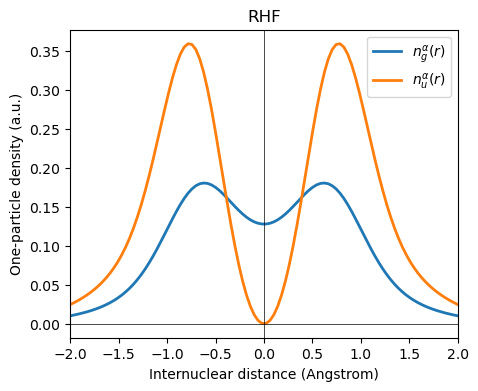

In [16]:
plt.figure(figsize=(5,4))

plt.plot(r, one_part_g_den_z, lw=2, label=r"$n^\alpha_g({r})$")
plt.plot(r, one_part_u_den_z, lw=2, label=r'$n^\alpha_u({r})$')
plt.axhline(color='k', linewidth=0.5)
plt.axvline(0.0, color='k', linewidth=0.5)
plt.xlim([-2,2])
plt.title(r'One-particle densities')
plt.xlabel(r'RHF Internuclear distance (Angstrom)')
plt.ylabel(r'One-particle density (a.u.)')
plt.legend()

plt.show()

#### Discuss the key feature difference in these densities that explains covalent bonding

The gerade orbital, $\sigma_g$, has density between the two nuclei while the ungerade orbital, $\sigma_u$ has zero density in the midpoint between the two nuclei meaning that there is no bonding between the nuclei in this situation. This is why they are referred to as bonding and anti-bonding, respectively.

### 3. Create a potential energy curve

In [56]:
# OBS this code is complete
scf_hf_drv.ostream.mute()

basis_set = "6-311G"

# Atomic coordinates in units of Bohr
template ="""
H    0.0000    0.0000    0.0000
H    0.0000    0.0000    """

n = 20
hf_energies = []
distances = np.linspace(0.7, 10.0, n)

for d in distances:
    mol_str = template + str(d)
    molecule = vlx.Molecule.read_str(mol_str, units='au')
    basis = vlx.MolecularBasis.read(molecule, basis_set)
    
    scf_tmp_results = scf_hf_drv.compute(molecule, basis)
    hf_energies.append(scf_hf_drv.get_scf_energy())

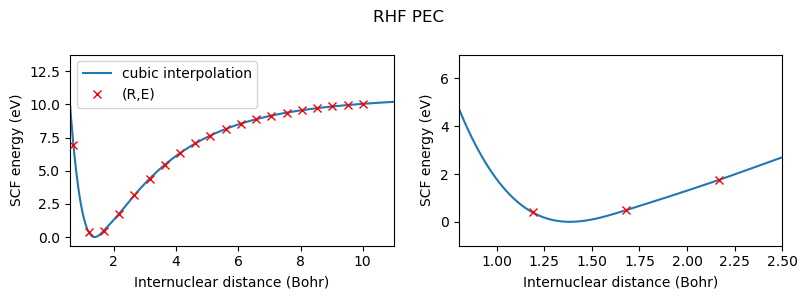

In [57]:
# we are asked to shift the energy such that the energy minimum energy defines the zero level
# therefore, when we

# interpolate the data points
hf_energies_ev = np.array(hf_energies) * vlx.hartree_in_ev()
rhf_spline_func = interpolate.CubicSpline(distances, hf_energies_ev)

d = np.linspace(0.5, 12, num=1000)
rhf_spline = rhf_spline_func(d)
e_min = rhf_spline.min()

# plot the data points and the interpolation
plt.figure(figsize = (8,3))

plt.subplot(1,2,1)
plt.plot(d, rhf_spline-e_min, label='cubic interpolation')
plt.plot(distances, hf_energies_ev-e_min, 'rx', markersize=6, label = '(R,E)')
plt.xlim([0.6,11.0])
plt.xlabel('Internuclear distance (Bohr)')
plt.ylabel('SCF energy (eV)')
plt.legend()

# zoom in on the well to decide region to add more points
plt.subplot(1,2,2)
plt.plot(d, rhf_spline-e_min)
plt.plot(distances, hf_energies_ev-e_min, 'rx')
plt.xlim([0.8,2.5])
plt.ylim([-1, 7])
plt.xlabel('Internuclear distance (Bohr)')
plt.ylabel('SCF energy (eV)')

plt.suptitle('RHF PEC')
plt.tight_layout()
plt.show()

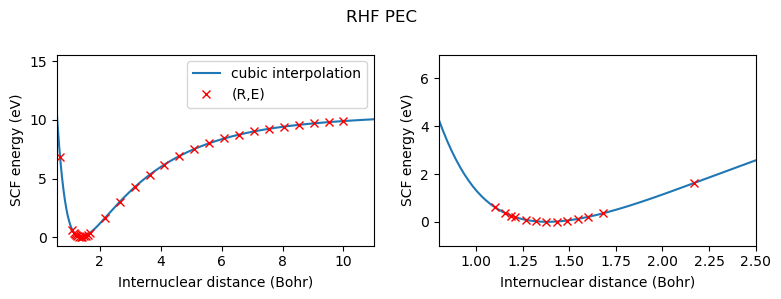

In [58]:
# here iterate to apply denser grid in well

# energy minimum between 1.1 and 1.6, so applying denser grid 
hf_energies = []
distances = np.linspace(0.7, 10.0, n)
well = np.linspace(1.1, 1.6, n//2)
distances = np.append(distances, well)
distances = np.sort(distances)

for d in distances:
    mol_str = template + str(d)
    molecule = vlx.Molecule.read_str(mol_str, units='au')
    basis = vlx.MolecularBasis.read(molecule, basis_set)
    
    scf_tmp_results = scf_hf_drv.compute(molecule, basis)
    hf_energies.append(scf_hf_drv.get_scf_energy())

hf_energies_ev = np.array(hf_energies) * vlx.hartree_in_ev()
rhf_spline_func = interpolate.CubicSpline(distances, hf_energies_ev)

d = np.linspace(0.5, 12, num=1000)
rhf_spline = rhf_spline_func(d)
e_min = rhf_spline.min()

# plot the data points and the interpolation
plt.figure(figsize = (8,3))

plt.subplot(1,2,1)
plt.plot(d, rhf_spline-e_min, label='cubic interpolation')
plt.plot(distances, hf_energies_ev-e_min, 'rx', markersize=6, label = '(R,E)')
plt.xlim([0.6,11.0])
plt.xlabel('Internuclear distance (Bohr)')
plt.ylabel('SCF energy (eV)')
plt.legend()

# zoom in on the well to decide region to add more points
plt.subplot(1,2,2)
plt.plot(d, rhf_spline-e_min)
plt.plot(distances, hf_energies_ev-e_min, 'rx')
plt.xlim([0.8,2.5])
plt.ylim([-1, 7])
plt.xlabel('Internuclear distance (Bohr)')
plt.ylabel('SCF energy (eV)')

plt.suptitle('RHF PEC')
plt.tight_layout()
plt.show()

### 4. Determine the equilibrium bond length and compare to experiment
\**Tip: add more distance points in the well of the PEC and run the calculation from (3.) again*

\**OBS: the equilibrium bond length is the minimum of the interpolation curve*

In [64]:
# determine equilibrium distance from min(E)
energy_spline = rhf_spline_func(d)
min_index = np.where(energy_spline == min(energy_spline))
R_equi = d[min_index][0]

print(f'Equilibrium distance from RHF: {R_equi * vlx.bohr_in_angstrom():2.4f} Angstrom')

Equilibrium distance from RHF: 0.7336 Angstrom


The equilibrium bond length has been determined to be 0.734 Angstrom. The experimental value is 0.741 Angstrom. Our calculations underestimate the bond length. This error arises from the ionic contributions in the HF wavefunction

$$
| \Psi_{HF} \rangle = \frac{1}{2} \left[ | \psi_{A}, \psi_{\bar{A}} \rangle + | \psi_{B}, \psi_{\bar{B}} \rangle + | \psi_{A} , \psi_{\bar{B}} \rangle + | \psi_{B} , \psi_{\bar{A}} \rangle\right]
$$

which creates an unphysical attraction that pulls the two nuclei too close to eachother.

### 5. Determine the bond energy from the HF calculation

In [65]:
# we estimate the bond energy to be the energy difference between the minimum and the energy at the longest interatomic distance we have computed
e_bond = rhf_spline[-1] - e_min
print(f"Bond energy estimate from RHF: {e_bond:2.4f} eV")

Bond energy estimate from RHF: 10.1951 eV


The bond energy is not well-defined in the RHF calculation since the dissociation limit is poorly described due to the ionic terms of the wavefunction. The two charged elements will attract each other in the dissociation limit but physically no such Coulombic interaction should be found since the dissociation is homolytic.

The estimated bond energy is 10.20 eV. This is much higher than the experimental result which is defined as the energy difference between the dihydrogen molecule at the equilibrium bond distance and two atomic hydrogens, that is 4.478 eV. The coulombic interaction between the fragments ionic fragments in the HF description hinders the dissociation.

### 6. Create a UHF potential energy curve

In [66]:
basis_set = "6-311G"
scf_uhf_drv = vlx.ScfUnrestrictedDriver()
scf_uhf_drv.ostream.mute()

uhf_energies = []

# Atomic coordinates in units of Bohr
template ="""
H    0.0000    0.0000    0.0000
H    0.0000    0.0000    """

n = 20
hf_energies = []
distances = np.linspace(0.7, 10.0, n)

for d in distances:
    mol_str = template + str(d)
    molecule = vlx.Molecule.read_str(mol_str, units='au')
    molecule.set_multiplicity(3)
    basis = vlx.MolecularBasis.read(molecule, basis_set)
    
    scf_tmp_results = scf_uhf_drv.compute(molecule, basis)
    uhf_energies.append(scf_uhf_drv.get_scf_energy())

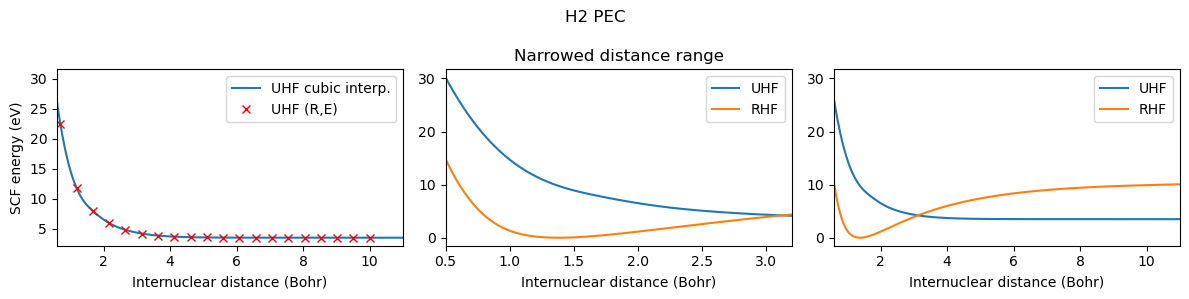

In [75]:
# plot the two PECs together
plt.figure(figsize = (12,3))

uhf_energies_ev = np.array(uhf_energies) * vlx.hartree_in_ev()
uhf_spline_func = interpolate.CubicSpline(distances, uhf_energies_ev)
d = np.linspace(0.5, 12, num=1000)
uhf_spline = uhf_spline_func(d)
uhf_e_min = uhf_spline.min()

plt.subplot(1,3,1)
plt.plot(d, uhf_spline-e_min, label='UHF cubic interp.')
plt.plot(distances, uhf_energies_ev-e_min, 'rx', markersize=6, label = 'UHF (R,E)')
plt.xlim([0.6,11.0])
plt.xlabel('Internuclear distance (Bohr)')
plt.ylabel('SCF energy (eV)')
plt.legend()

plt.subplot(1,3,2)
plt.plot(d, uhf_spline-e_min, label='UHF')
plt.plot(d, rhf_spline-e_min, label='RHF')
plt.xlim([0.5, 3.2])
# plt.ylim([-31, -26])
plt.xlabel('Internuclear distance (Bohr)')
plt.title('Narrowed distance range')
plt.legend()

plt.subplot(1,3,3)
plt.plot(d, uhf_spline-e_min, label='UHF')
plt.plot(d, rhf_spline-e_min, label='RHF')
plt.xlim([0.6,11.0])
plt.xlabel('Internuclear distance (Bohr)')
plt.legend()

plt.suptitle('H2 PEC')
plt.tight_layout()
plt.show()

In [79]:
# estimate the bond energy as the difference between the RHF minimum and the UHF energy at the long internuclear distance
e_bond = uhf_spline[-1] - e_min
print(f"Bond energy estimate from RHF: {e_bond:2.4f} eV")

Bond energy estimate from RHF: 3.4941 eV


#### Compare the PECs

The potential curve for UHF shows no bonding interaction between the two hydrogen atoms, thus no bond energy can be calculated. To obtain the UHF curves illustrated in the literature, the appropiate method is called symmetry-broken UHF.

*The following is likely to be a flawed reflection*

In the UHF calculations where we force the system to be a triplet, we are basically faking a system of two separate H atoms, which is closer to how the dissociation behaves near bond breaking. 

The bond energy estimated from the difference between RHF and UHF minimum energies is 3.5 eV, which is now lower than the experimental value of 4.5 eV but much better than 

## THE END